In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import multiprocessing
num_workers = multiprocessing.cpu_count()

In [3]:
num_workers

64

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
from PIL import ImageFilter
# from tensorflow.python import keras
from tensorflow import keras
from tensorflow.keras.models import load_model
# import tensorflow_hub as hub
# from tensorflow.keras.applications import EfficientNetB4, MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import *

# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import os
# import necessary libraries
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

2023-07-21 20:32:47.678646: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
# df=pd.read_csv("./datasets/Kaggle/retinopathy_solution.csv")
# df2=pd.read_csv("./datasets/Kaggle/trainLabels.csv")
# df=pd.concat([df, df2])
# df=df[['image','level']]
# df= df.drop_duplicates()
# df.to_csv('./datasets/Kaggle/all_labels.csv',header=True, index=False)
# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')
# mixed_precision.set_global_policy('float32')
import warnings
warnings.filterwarnings('ignore')
dataset_path = r'./datasets/'

idrid_path = dataset_path + "IDRiD/"
kaggle_path = dataset_path + "Kaggle/"
messidor_path = dataset_path + "Messidor-2/"

idrid_path_train_test = dataset_path + "IDRiD/images/train/"
kaggle_path_train_test = dataset_path + "Kaggle/images/"
messidor_path_train_test = dataset_path + "Messidor-2/images/"

kaggle_csv = "./datasets/Kaggle/all_labels.csv"
# kaggle_csv = "./datasets/Kaggle/trainLabels.csv"
idrid_csv = idrid_path + "a. IDRiD_Disease Grading_Training Labels.csv"
messidor_csv = messidor_path + "reference.csv"

idrid_columns = ['Image name', 'Retinopathy grade']
kaggle_columns = ['image', 'level']
messidor_columns = ['i_image','i_adjudicated_dr_grade']
# Define the paths to the image directory and the CSV file
train_image_dir: str = idrid_path_train_test
# train_image_dir: str = kaggle_path_train_test
# train_image_dir: str = messidor_path_train_test
# csv_file_train = idrid_path + 'a. IDRiD_Disease Grading_Training Labels.csv'
# csv_file_test = idrid_path + 'b. IDRiD_Disease Grading_Testing Labels.csv'
csv_file = idrid_csv #kaggle_csv #messidor_csv
# Loading the dataset
df = pd.read_csv(csv_file)

# #uncomment for idrid data
df = df[idrid_columns]
print(df.shape)
df['Image name'] = df['Image name'].astype(str) + ".png"
df['Retinopathy grade'] = df['Retinopathy grade'].astype(str)
df.rename(columns={'Image name': 'img_name', 'Retinopathy grade': 'label'}, inplace=True)
df.dropna(how='all', inplace = True)
df = df[df['label'].notnull()]
df_shuffled = df.sample(frac=1, random_state=1)
df2 = df_shuffled.copy()
# df2 = df_shuffled.iloc[:36]
print(df2.shape)

# # #uncomment for kaggle data
# df = df[kaggle_columns]
# df['image'] = df['image'].astype(str) + ".png"
# df['level'] = df['level'].astype(str)
# df.rename(columns={'image': 'img_name', 'level': 'label'}, inplace=True)
# df.dropna(how='all', inplace = True)
# df = df[df['label'].notnull()]
# df_shuffled = df.sample(frac=1, random_state=1)
# df2=df_shuffled.iloc[:2048]
# df1=df_shuffled.iloc[2048:50048] #including 6000*4 number of elements i.e. max 6000 batches of 4 of which 4500 for training and 1500 for validation
# print(df1.head(),df1.shape, df2.head(),df2.shape)


##uncomment for messidor data
# df = df[messidor_columns]
# df['image'] = df['image'].astype(str) + ".png"
# df['level'] = df['level'].astype(str)
# df.rename(columns={'i_image': 'img_name', 'i_adjudicated_dr_grade': 'label'}, inplace=True)
# df.dropna(how='all', inplace = True)
# df = df[df['label'].notnull()]
# df_shuffled = df.sample(frac=1, random_state=1)
# df2 = df_shuffled.copy()
# print(df2.shape)

# Creating the image generator
# datagen = ImageDataGenerator(rescale=1. / 255)
#rotation_range --> minus to plus number of degrees of rotation
'''
ONE POSSIBLE PREPROCESSING FUNC preprocessing_function=lambda x: np.array(PIL.Image.fromarray(x).filter(ImageFilter.GaussianBlur(radius=2)).getdata()).reshape(data.size[::-1]+(-1,)).astype(np.uint8) if (np.random.rand() < 0.33) else np.array(PIL.Image.fromarray(x).filter(ImageFilter.SHARPEN).getdata()).reshape(data.size[::-1]+(-1,)).astype(np.uint8) if (np.random.rand() < 0.67) else x,
'''
test_datagen = ImageDataGenerator(rescale=None)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df2,
    directory=train_image_dir,
    x_col="img_name",
    y_col="label",
    target_size=(512, 512),
    batch_size=12,
    shuffle=False,
    class_mode='categorical'
    )

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
(413, 2)
(413, 2)
Found 413 validated image filenames belonging to 5 classes.


2023-07-21 20:32:49.802239: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-07-21 20:32:49.803459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-07-21 20:32:49.828805: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-21 20:32:49.828850: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


In [7]:
models = ['EffNet_B4_imagenet','EffNet_B5_imagenet','EffNet_B6_imagenet','EffNet_B7_imagenet','EffNet_B4_imagenet_norescale_sameastfmodel','EffNet_B5_imagenet_norescale_sameastfmodel','EffNet_B6_imagenet_norescale_sameastfmodel','EffNet_B7_imagenet_norescale_sameastfmodel','EffNet_B5_imagenet_regularized_highdropout','EffNet_B4_imagenet_classbalanced','EffNet_B4_imagenet_norescale_sameastfmodel_rev','EffNet_B5_imagenet_norescale_sameastfmodel_rev','EffNet_B6_imagenet_norescale_sameastfmodel_rev','EffNet_B7_imagenet_norescale_sameastfmodel_rev']
ensembles = ['teacher_ensemble_v1_b4b5b6b7','teacher_ensemble_v2_b4b5b6b7','teacher_ensemble_v3_b4b5b6','teacher_ensemble_v4_b4b5b6_retcad']
# for model in models:
#     # specify the path to the saved logs
#     log_path = './logs/exp_teacher/'+model+'/'
#     # stud_log_path = './logs/exp_student/MobNetv3small_0.75_224'
#     # create an event accumulator object to load the training and validation logs separately
#     train_log_path = log_path + '/train'
#     validation_log_path = log_path + '/validation'
#     train_event_acc = EventAccumulator(train_log_path)
#     validation_event_acc = EventAccumulator(validation_log_path)
#     train_event_acc.Reload()
#     validation_event_acc.Reload()


#     # get the available tags
#     tags = validation_event_acc.Tags()
#     print(tags)
# #     print('TYPE:',type(train_event_acc.Scalars()))

#     # get the training and validation metrics
#     training_loss = train_event_acc.Scalars('epoch_loss')
#     validation_loss = validation_event_acc.Scalars('epoch_loss')
#     try:
#         training_accuracy = train_event_acc.Scalars('epoch_accuracy')
#     except:
#         training_accuracy = train_event_acc.Scalars('epoch_categorical_accuracy')
#     try:
#         validation_accuracy = validation_event_acc.Scalars('epoch_accuracy')
#     except:
#         validation_accuracy = validation_event_acc.Scalars('epoch_categorical_accuracy')

#     # plot the metrics
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#     fig.suptitle('Training Metrics for model: '+model)

#     ax1.plot([scalar.step for scalar in training_loss], [scalar.value for scalar in training_loss], label='training_loss')
#     ax1.plot([scalar.step for scalar in validation_loss], [scalar.value for scalar in validation_loss], label='validation_loss')
#     ax1.legend()
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')

#     ax2.plot([scalar.step for scalar in training_accuracy], [scalar.value for scalar in training_accuracy], label='training_accuracy')
#     ax2.plot([scalar.step for scalar in validation_accuracy], [scalar.value for scalar in validation_accuracy], label='validation_accuracy')
#     ax2.legend()
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Accuracy')
#     # plt.title()
#     plt.show()

# # event_acc = EventAccumulator(stud_log_path)
# # event_acc.Reload()

# # # get the training and validation metrics
# # training_loss = event_acc.Scalars('loss')
# # validation_loss = event_acc.Scalars('val_loss')
# # training_accuracy = event_acc.Scalars('accuracy')
# # validation_accuracy = event_acc.Scalars('val_accuracy')

# # # plot the metrics
# # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# # fig.suptitle('Training Metrics')

# # ax1.plot([scalar.step for scalar in training_loss], [scalar.value for scalar in training_loss], label='training_loss')
# # ax1.plot([scalar.step for scalar in validation_loss], [scalar.value for scalar in validation_loss], label='validation_loss')
# # ax1.legend()
# # ax1.set_xlabel('Epoch')
# # ax1.set_ylabel('Loss')

# # ax2.plot([scalar.step for scalar in training_accuracy], [scalar.value for scalar in training_accuracy], label='training_accuracy')
# # ax2.plot([scalar.step for scalar in validation_accuracy], [scalar.value for scalar in validation_accuracy], label='validation_accuracy')
# # ax2.legend()
# # ax2.set_xlabel('Epoch')
# # ax2.set_ylabel('Accuracy')

# # plt.show()

In [8]:
# models = ['MobNetv3small_1.0_rev','MobNetv3small_1.0_rev_minimalistic','MobNetv3small_0.75_rev',
#           'EffNet_B0_imagenet_norescale_sameastfmodel_rev',
#           'EffNet_B1_imagenet_norescale_sameastfmodel_rev',
#           'EffNet_B2_imagenet_norescale_sameastfmodel_rev',
#           'student_scratch_ensemble_b0b1_NoActivation','student_scratch_ensemble_b0b1b2_NoActivation']
# models = ['EffNet_B0_imagenet_Glaucoma_exp2']
# #'MobNetv3small_0.75_224','MobNetv3small_0.75_classbalanced','MobNetv3small_1.0',
# for model in models[-1:]:
#     # specify the path to the saved logs
#     log_path = './logs/exp_student/'+model+'/'
#     # stud_log_path = './logs/exp_student/MobNetv3small_0.75_224'
#     # create an event accumulator object to load the training and validation logs separately
#     train_log_path = log_path + '/train'
#     validation_log_path = log_path + '/validation'
#     train_event_acc = EventAccumulator(train_log_path)
#     validation_event_acc = EventAccumulator(validation_log_path)
#     train_event_acc.Reload()
#     validation_event_acc.Reload()


#     # get the available tags
#     tags = validation_event_acc.Tags()
#     print(tags)
# #     print('TYPE:',type(train_event_acc.Scalars()))

#     # get the training and validation metrics
#     training_loss = train_event_acc.Scalars('epoch_loss')
#     validation_loss = validation_event_acc.Scalars('epoch_loss')
#     try:
#         training_accuracy = train_event_acc.Scalars('epoch_accuracy')
#     except:
#         training_accuracy = train_event_acc.Scalars('epoch_categorical_accuracy')
#     try:
#         validation_accuracy = validation_event_acc.Scalars('epoch_accuracy')
#     except:
#         validation_accuracy = validation_event_acc.Scalars('epoch_categorical_accuracy')

#     # plot the metrics
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
#     fig.suptitle('Training Metrics for model: '+model)

#     ax1.plot([scalar.step for scalar in training_loss], [scalar.value for scalar in training_loss], label='training_loss')
#     ax1.plot([scalar.step for scalar in validation_loss], [scalar.value for scalar in validation_loss], label='validation_loss')
#     ax1.legend()
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')

#     ax2.plot([scalar.step for scalar in training_accuracy], [scalar.value for scalar in training_accuracy], label='training_accuracy')
#     ax2.plot([scalar.step for scalar in validation_accuracy], [scalar.value for scalar in validation_accuracy], label='validation_accuracy')
#     ax2.legend()
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Accuracy')
#     # plt.title()
#     plt.show()

In [9]:
# m = load_model('./models/teacher_ensembles/ensemble_v3_NoActivation.h5')
# m.summary()

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['epoch_categorical_accuracy', 'epoch_loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['epoch_categorical_accuracy', 'epoch_loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


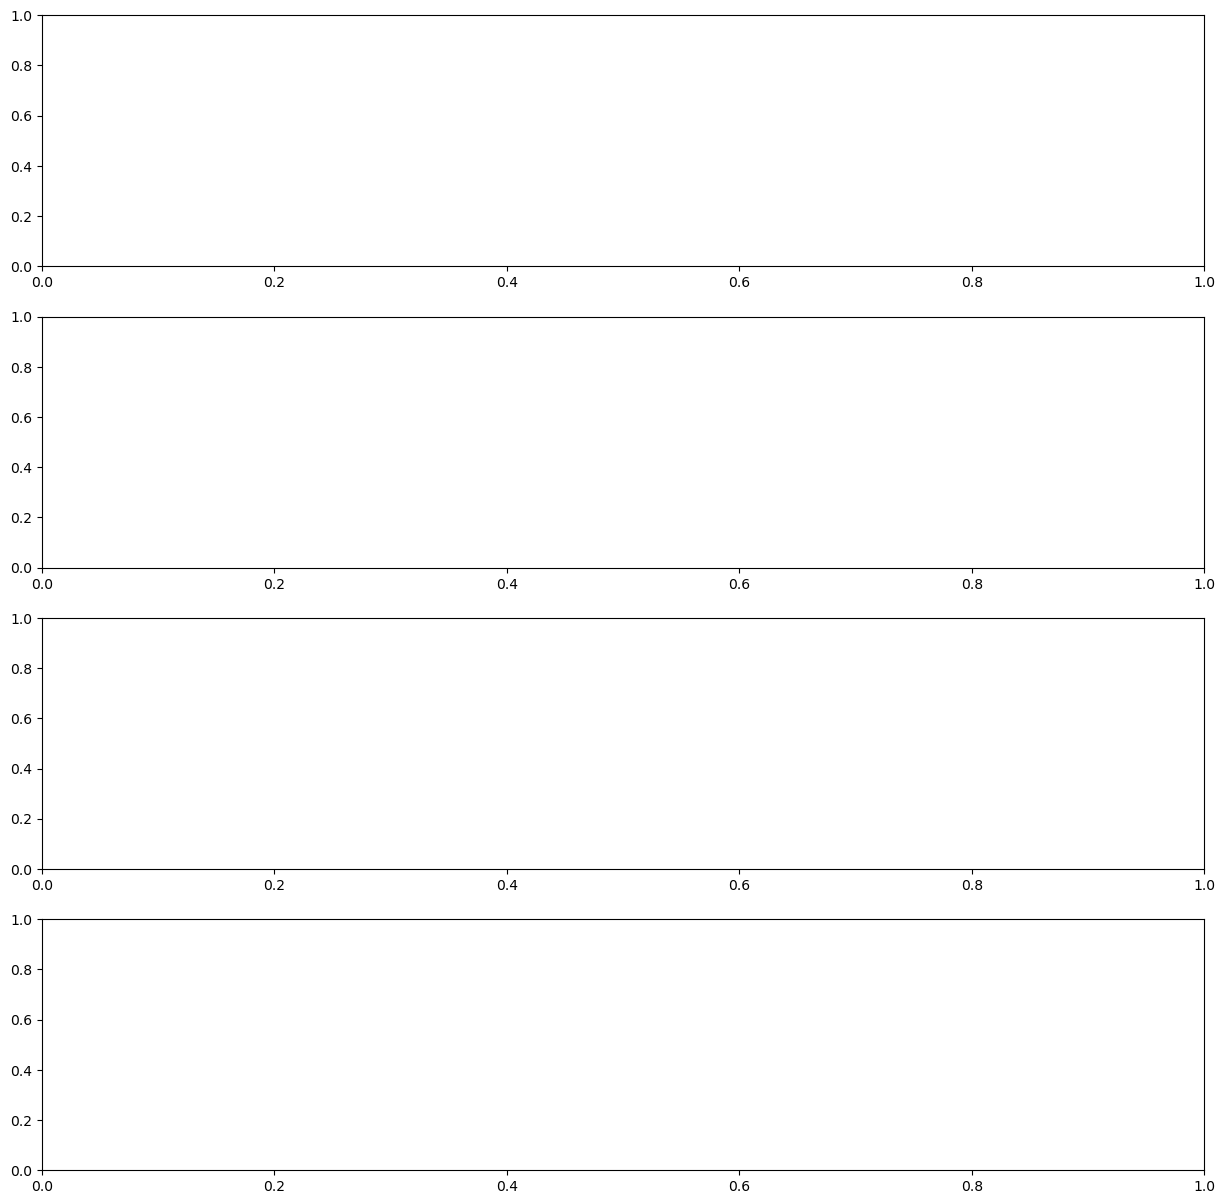

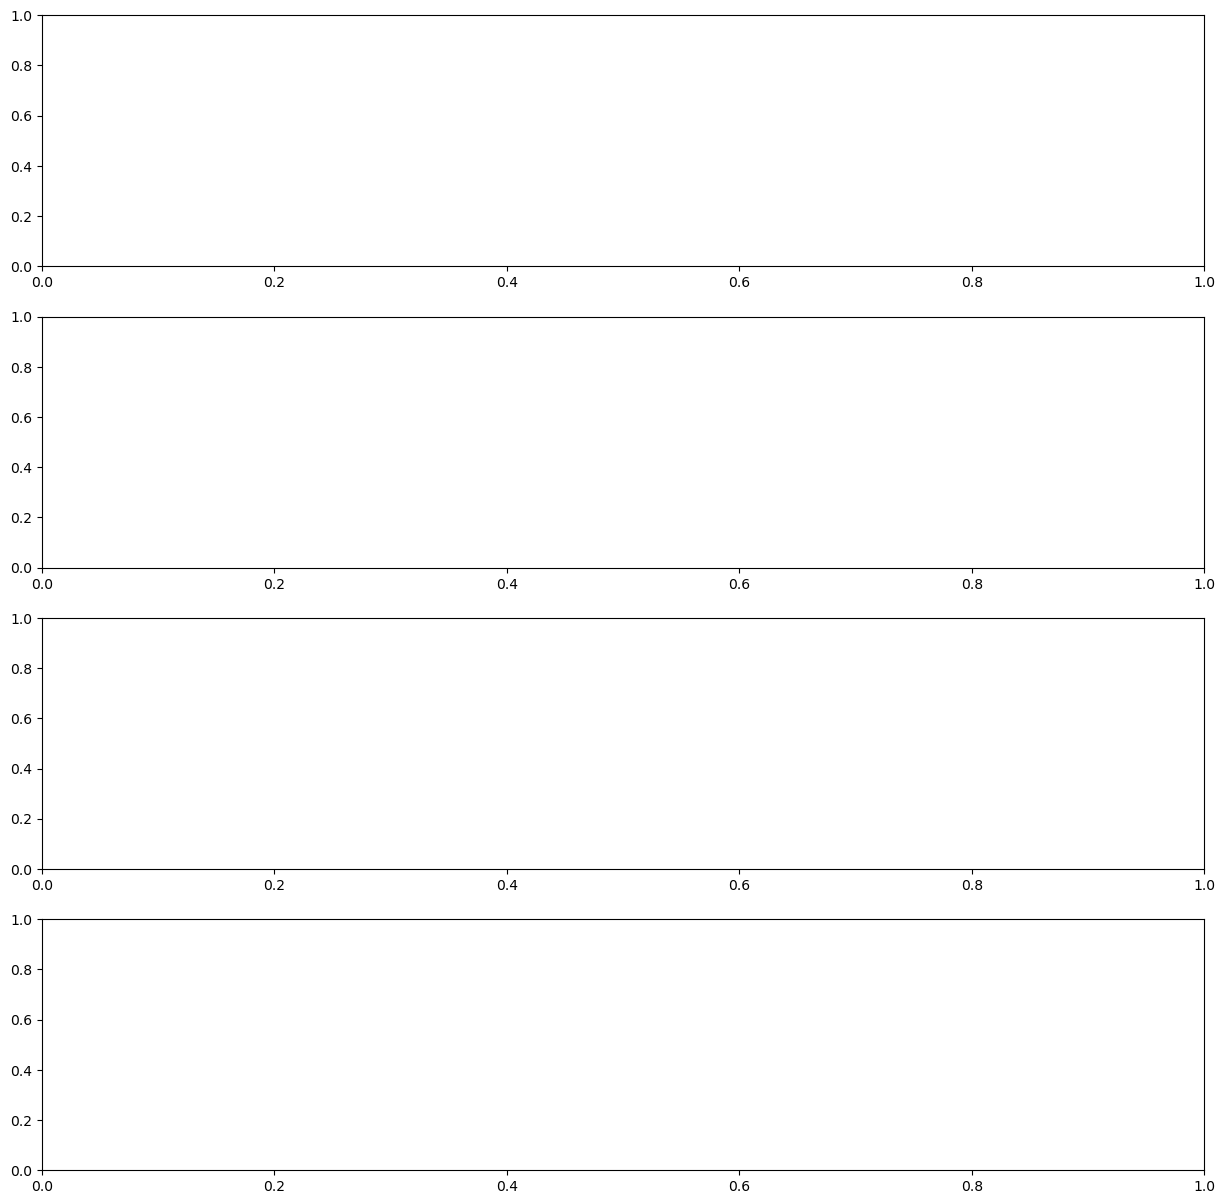

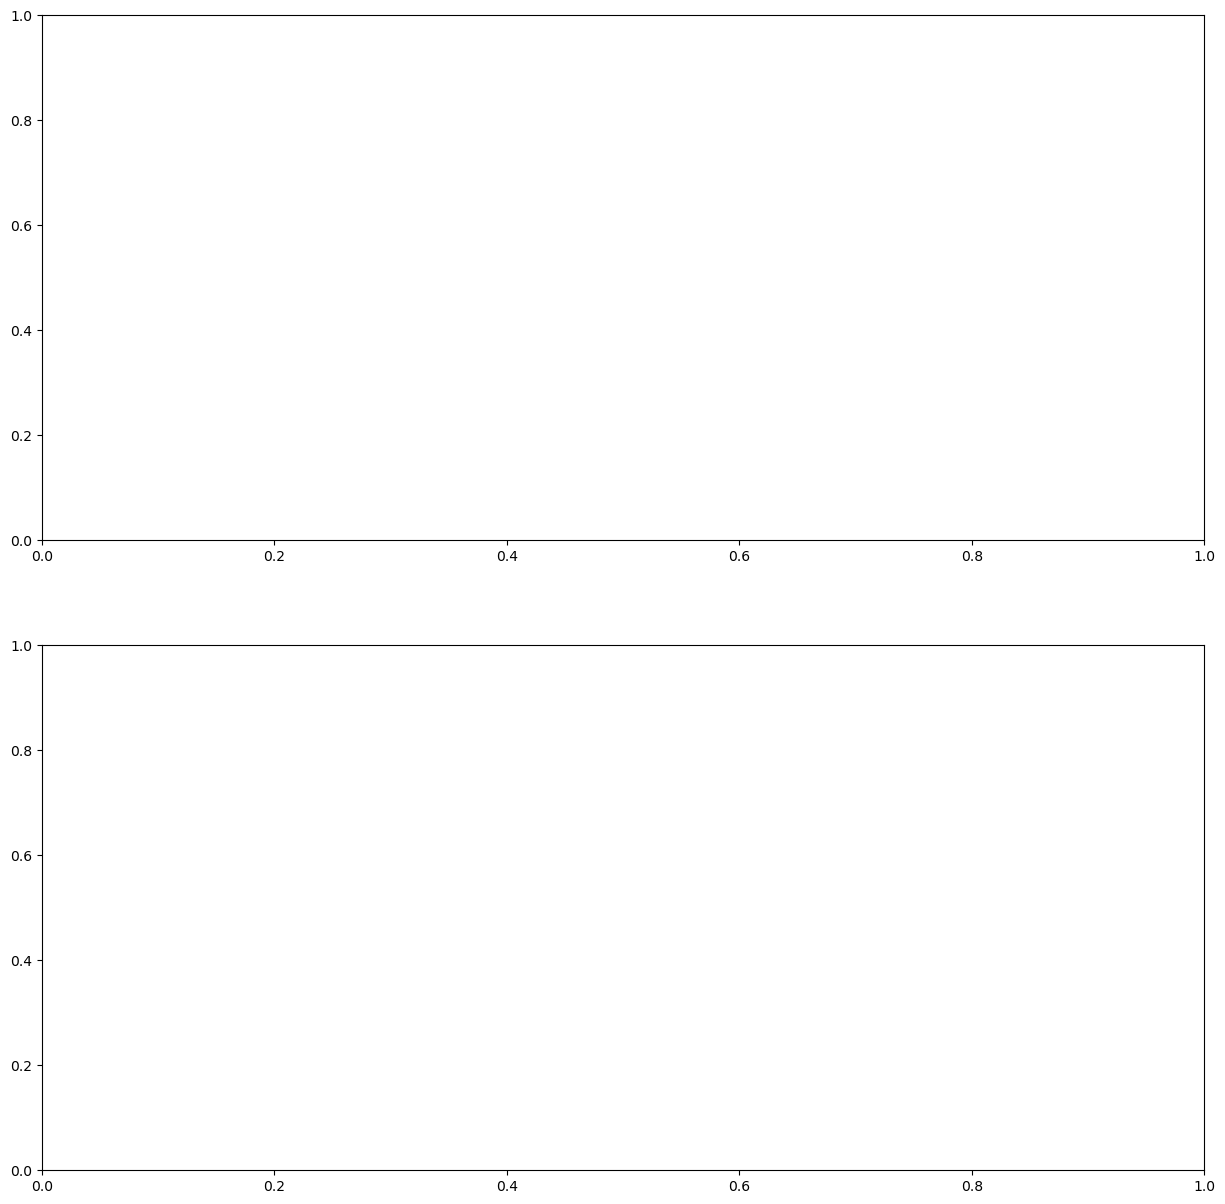

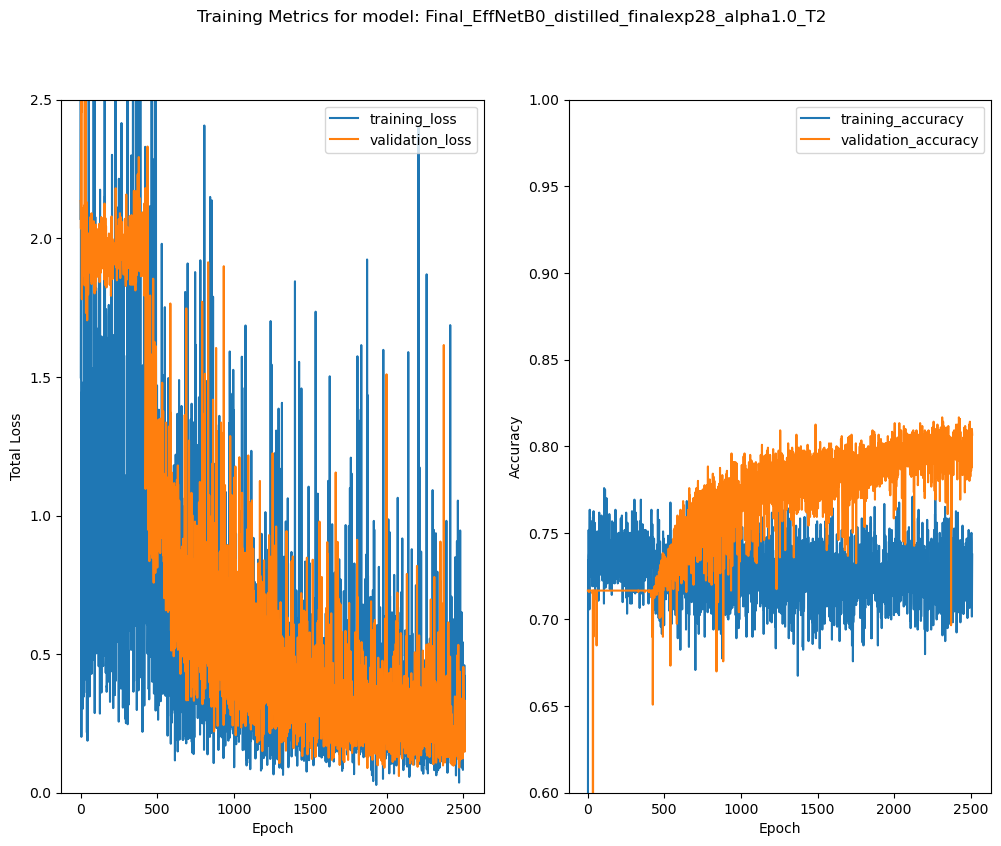

In [10]:
models = ['Final_MobNetv3small_1.0_minimalistic_distilled_finalexp1_alpha0_T1',
          'Final_MobNetv3small_1.0_minimalistic_distilled_finalexp2_alpha0.9_T5',
          'Final_EffNetB0_distilled_finalexp3_alpha0.9_T5',
          'Final_EffNetB0_distilled_finalexp4_alpha0.9_T5',
          'Final_EffNetB1_distilled_finalexp5_alpha0.9_T5',
          'Final_EffNetB1_distilled_finalexp6_alpha1.0_T5',
          'Final_EffNetB0_distilled_finalexp7_alpha0.7_T3',
          'Final_EffNetB1_distilled_finalexp8_alpha0.7_T3',
          'Final_EffNetB2_distilled_finalexp9_alpha0.9_T3',
          'Final_EffNetB2_distilled_finalexp10_alpha1.0_T20',
          'Final_EffNetB2_distilled_finalexp11_alpha1.0_T3',
          'Final_EffNetB2_distilled_finalexp12_alpha1.0_T1',
          'Final_EffNetB2_distilled_finalexp13_alpha1.0_T1',
          'Final_EffNetB2_distilled_finalexp14_alpha0.1_T3',
          'Final_EffNetB2_distilled_finalexp15_alpha0.9_T3',
          'Final_EffNetB0_distilled_finalexp16_alpha0.9_T3',
          'Final_EffNetB1_distilled_finalexp17_alpha0.9_T3',
          'Final_EffNetB0_distilled_withTclassifier_finalexp18_alpha0.9_T3',
          'Final_EffNetB1_distilled_withTclassifier_finalexp19_alpha0.9_T3',
          'Final_EffNetB2_distilled_withTclassifier_finalexp20_alpha0.9_T3',
          'Final_EffNetB0_distilled_finalexp21_alpha0.9_T3',
          'Final_EffNetB0_distilled_finalexp22_alpha0.9_T3',
          'Final_EffNetB0_distilled_finalexp23_alpha0.9_T3',
          'Final_EffNetB0_distilled_finalexp24_alpha0.9_T3',
          'Final_EffNetB1_distilled_finalexp25_alpha0.9_T3',
          'Final_EffNetB2_distilled_finalexp26_alpha0.9_T3',
          'Final_EffNetB0_distilled_finalexp27_alpha1.0_T2',
          'Final_EffNetB0_distilled_finalexp28_alpha1.0_T2']
# models = ['GLAUCOMA/Final_EffNetB0_Glaucoma_distilled_finalexp28_alpha0.9_T3']
# alphadict = {"Experiment Name":"","Training Set - Alpha":"","Validation Set - Alpha":""}
# alphalist = [alphadict]
# alphadf = pd.DataFrame(alphalist)
for model in models[-2:]:
    # specify the path to the saved logs
    log_path = './logs/exp_distillation/'+model
#     log_path = './logs/exp_student/'+model
    # stud_log_path = './logs/exp_student/MobNetv3small_0.75_224'
    # create an event accumulator object to load the training and validation logs separately
#     train_log_path = log_path + 'train/20230508-221959/metrics'
    train_log_path = log_path + '/train/'
    validation_log_path = log_path + '/validation/'
    train_event_acc = EventAccumulator(train_log_path)
    validation_event_acc = EventAccumulator(validation_log_path)
    train_event_acc.Reload()
    validation_event_acc.Reload()


    # get the available tags
    tags = train_event_acc.Tags()
    print(tags)
#     print('TYPE:',type(train_event_acc.Scalars('epoch_distillation_loss')))

    # get the training and validation metrics
#     training_student_loss = train_event_acc.Scalars('epoch_student_loss')
#     training_distillation_loss = train_event_acc.Scalars('epoch_distillation_loss')
    training_loss = train_event_acc.Scalars('epoch_loss')
#     print(training_loss)
#     validation_student_loss = validation_event_acc.Scalars('epoch_student_loss')
#     validation_distillation_loss = validation_event_acc.Scalars('epoch_distillation_loss')
    validation_loss = validation_event_acc.Scalars('epoch_loss')
    try:
        training_accuracy = train_event_acc.Scalars('epoch_accuracy')
#         print(training_accuracy)
    except:
        training_accuracy = train_event_acc.Scalars('epoch_categorical_accuracy')
    try:
        validation_accuracy = validation_event_acc.Scalars('epoch_accuracy')
    except:
        validation_accuracy = validation_event_acc.Scalars('epoch_categorical_accuracy')

   # plot the metrics
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 15))
    fig, axs = plt.subplots(2, 2, figsize=(12, 9))
    (ax1, ax2), (ax3, ax4) = axs
    fig, (ax3, ax4) = plt.subplots(2, 1, figsize=(15, 15))
    fig, axs = plt.subplots(1, 2, figsize=(12, 9))
    (ax3, ax4) = axs
    fig.suptitle('Training Metrics for model: '+model)

#     ax1.plot([scalar.step for scalar in training_student_loss], [scalar.value for scalar in training_student_loss], label='training_student_loss')
#     ax1.plot([scalar.step for scalar in validation_student_loss], [scalar.value for scalar in validation_student_loss], label='validation_student_loss')
#     ax1.legend()
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Student Loss')
# #     ax1.set_ylim((0, 2.5))

#     ax2.plot([scalar.step for scalar in training_distillation_loss], [scalar.value for scalar in training_distillation_loss], label='training_distillation_loss')
#     ax2.plot([scalar.step for scalar in validation_distillation_loss], [scalar.value for scalar in validation_distillation_loss], label='validation_distillation_loss')
#     ax2.legend()
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('Distillation Loss')
# #     ax2.set_ylim((0, 2.5))
    
    ax3.plot([scalar.step for scalar in training_loss], [scalar.value for scalar in training_loss], label='training_loss')
    ax3.plot([scalar.step for scalar in validation_loss], [scalar.value for scalar in validation_loss], label='validation_loss')
    ax3.legend()
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Total Loss')
    ax3.set_ylim((0, 2.5))
    
    ax4.plot([scalar.step for scalar in training_accuracy], [scalar.value for scalar in training_accuracy], label='training_accuracy')
    ax4.plot([scalar.step for scalar in validation_accuracy], [scalar.value for scalar in validation_accuracy], label='validation_accuracy')
    ax4.legend()
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.set_ylim((0.6, 1.0))
#     plt.title()
#     plt.show()
    
#     TL = [training_loss[i].value for i in range(len(validation_distillation_loss))]
#     VL = [validation_loss[i].value for i in range(len(validation_distillation_loss))]
#     TSL = [training_student_loss[i].value for i in range(len(validation_distillation_loss))]
#     VSL = [validation_student_loss[i].value for i in range(len(validation_distillation_loss))]
#     TDL = [training_distillation_loss[i].value for i in range(len(validation_distillation_loss))]
#     VDL = [validation_distillation_loss[i].value for i in range(len(validation_distillation_loss))]
#     training_alpha_mean_all_epochs = (np.sum(np.array(TL)) - np.sum(np.array(TSL)))/(np.sum(np.array(TDL)) - np.sum(np.array(TSL)))
#     validation_alpha_mean_all_epochs = (np.sum(np.array(VL)) - np.sum(np.array(VSL)))/(np.sum(np.array(VDL)) - np.sum(np.array(VSL)))
#     TrainAlpha = (np.array(TL) - np.array(TSL))/(np.array(TDL) - np.array(TSL))
#     ValidationAlpha = (np.array(VL) - np.array(VSL))/(np.array(VDL) - np.array(VSL))
# #     new_row = {'Experiment Name':model,'Training Set - Alpha': np.round(training_alpha_mean_all_epochs,40),
# #                'Validation Set - Alpha':np.round(validation_alpha_mean_all_epochs,40)}
#     new_row = {'Experiment Name':"_".join(model.split("_")[1:]),'Training Set - Alpha': training_alpha_mean_all_epochs,
#                'Validation Set - Alpha':validation_alpha_mean_all_epochs}
#     alphadf = alphadf.append(new_row,ignore_index=True)
# #     print(model, np.round(training_alpha_mean_all_epochs,3), np.round(validation_alpha_mean_all_epochs,3))

In [111]:
alphadf=alphadf.drop(0)
alphadf.head(alphadf.shape[0])

Experiment Name Training Set - Alpha  \
1  EffNetB0_distilled_finalexp21_alpha0.9_T3             0.755432   
2  EffNetB0_distilled_finalexp22_alpha0.9_T3                  0.9   
3  EffNetB0_distilled_finalexp23_alpha0.9_T3                  0.9   
4  EffNetB0_distilled_finalexp24_alpha0.9_T3             0.832613   
5  EffNetB1_distilled_finalexp25_alpha0.9_T3             0.809696   
6  EffNetB2_distilled_finalexp26_alpha0.9_T3              0.79891   

  Validation Set - Alpha  
1               0.801898  
2                    0.9  
3                    0.9  
4               0.827671  
5               0.806495  
6               0.788779

In [20]:
TL = [training_loss[i].value for i in range(len(validation_distillation_loss))]
VL = [validation_loss[i].value for i in range(len(validation_distillation_loss))]
TSL = [training_student_loss[i].value for i in range(len(validation_distillation_loss))]
VSL = [validation_student_loss[i].value for i in range(len(validation_distillation_loss))]
TDL = [training_distillation_loss[i].value for i in range(len(validation_distillation_loss))]
VDL = [validation_distillation_loss[i].value for i in range(len(validation_distillation_loss))]

In [21]:
training_alpha_mean_all_epochs = (np.sum(np.array(TL)) - np.sum(np.array(TSL)))/(np.sum(np.array(TDL)) - np.sum(np.array(TSL)))
validation_alpha_mean_all_epochs = (np.sum(np.array(VL)) - np.sum(np.array(VSL)))/(np.sum(np.array(VDL)) - np.sum(np.array(VSL)))
TrainAlpha = (np.array(TL) - np.array(TSL))/(np.array(TDL) - np.array(TSL))
ValidationAlpha = (np.array(VL) - np.array(VSL))/(np.array(VDL) - np.array(VSL))
training_alpha_mean_all_epochs, validation_alpha_mean_all_epochs
# np.min(TrainAlpha),np.min(ValidationAlpha)

(0.8096962946867278, 0.8064953934655078)

| **Epoch** |  T_Acc  |  V_Acc  |  T_Loss |  V_Loss |  T_SLoss |  T_DLoss |  V_SLoss |  V_DLoss | **_ T_αlpha_** | **_ V_αlpha_** |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **0** | 1 | 0.861 | 0.443 | 0.209 | 0.142 | 0.443 | 0.398 | 0.171 | **_1_** | **_0.83333_** |
| **1** | 1 | 0.868 | 0.242 | 0.326 | 0.601 | 0.209 | 0.257 | 0.326 | **_0.91667_** | **_1_** |
| **2** | 0.874 | 0.861 | 0.194 | 0.247 | 0.181 | 0.197 | 0.121 | 0.259 | **_0.83333_** | **_0.91667_** |
| **3** | 1 | 0.85 | 0.569 | 0.155 | 0.356 | 0.569 | 0.313 | 0.123 | **_1_** | **_0.83333_** |
| **4** | 1 | 0.871 | 0.128 | 0.255 | 0.252 | 0.103 | 0.395 | 0.255 | **_0.83333_** | **_1_** |
| **5** | 1 | 0.849 | 0.492 | 0.26 | 0.606 | 0.469 | 0.261 | 0.26 | **_0.83333_** | **_1_** |
| **6** | 1 | 0.85 | 0.339 | 0.382 | 0.594 | 0.288 | 0.236 | 0.395 | **_0.83333_** | **_0.91667_** |
| **7** | 0.879 | 0.852 | 0.159 | 0.6 | 0.069 | 0.159 | 0.129 | 0.6 | **_1_** | **_1_** |
| **8** | 0.869 | 0.852 | 0.234 | 0.113 | 0.244 | 0.232 | 0.139 | 0.113 | **_0.83333_** | **_1_** |
| **9** | 0.867 | 0.858 | 0.768 | 0.185 | 1.465 | 0.42 | 0.221 | 0.178 | **_0.66667_** | **_0.83333_** |
| **10** | 0.861 | 0.852 | 0.165 | 0.344 | 0.299 | 0.153 | 0.089 | 0.368 | **_0.91667_** | **_0.91667_** |
| **11** | 0.858 | 0.837 | 0.121 | 0.496 | 0.178 | 0.116 | 0.58 | 0.496 | **_0.91667_** | **_1_** |
| **12** | 0.861 | 0.861 | 0.189 | 0.203 | 0.382 | 0.151 | 0.157 | 0.203 | **_0.83333_** | **_1_** |
| **13** | 0.855 | 0.852 | 0.287 | 0.241 | 0.392 | 0.277 | 0.319 | 0.225 | **_0.91667_** | **_0.83333_** |
| **14** | 0.878 | 0.857 | 0.371 | 0.583 | 0.771 | 0.335 | 0.454 | 0.595 | **_0.91667_** | **_0.91667_** |
| **15** | 0.868 | 0.862 | 0.427 | 0.535 | 0.781 | 0.25 | 0.94 | 0.454 | **_0.66667_** | **_0.83333_** |
| **16** | 0.851 | 0.851 | 0.268 | 0.522 | 0.258 | 0.269 | 0.765 | 0.441 | **_0.91667_** | **_0.75_** |
| **17** | 0.876 | 0.866 | 0.101 | 0.143 | 0.054 | 0.101 | 0.179 | 0.139 | **_1_** | **_0.91667_** |
| **18** | 0.863 | 0.861 | 0.377 | 0.214 | 1.003 | 0.252 | 0.042 | 0.214 | **_0.83333_** | **_1_** |
| **19** | 0.863 | 0.861 | 0.167 | 0.262 | 0.368 | 0.167 | 0.664 | 0.181 | **_1_** | **_0.83333_** |
| **20** | 0.869 | 0.858 | 0.136 | 0.46 | 0.316 | 0.119 | 0.764 | 0.399 | **_0.91667_** | **_0.83333_** |

In [29]:
print("Epoch|","T_Acc |", "V_Acc |", "T_Loss|", "V_Loss|","T_SLoss|","T_DLoss|","V_SLoss|","V_DLoss|","T_α|","V_α")
for i in range(len(training_accuracy)):
    print(i,"  |  ",np.round(training_accuracy[i].value,3),"|", np.round(validation_accuracy[i].value,3), "|", np.round(training_loss[i].value,3), "|",np.round(validation_loss[i].value,3), "|",np.round(training_student_loss[i].value,3), "|",np.round(training_distillation_loss[i].value,3), "|",np.round(validation_student_loss[i].value,3), "|",np.round(validation_distillation_loss[i].value,3), "|",np.round(TrainAlpha[i],5), "|",np.round(ValidationAlpha[i],5))

Epoch| T_Acc | V_Acc | T_Loss| V_Loss| T_SLoss| T_DLoss| V_SLoss| V_DLoss| T_α| V_α
0   |   0.87 | 0.861 | 0.443 | 0.209 | 0.142 | 0.443 | 0.398 | 0.171 | 1.0 | 0.83333
1   |   0.866 | 0.868 | 0.242 | 0.326 | 0.601 | 0.209 | 0.257 | 0.326 | 0.91667 | 1.0
2   |   0.874 | 0.861 | 0.194 | 0.247 | 0.181 | 0.197 | 0.121 | 0.259 | 0.83333 | 0.91667
3   |   0.85 | 0.85 | 0.569 | 0.155 | 0.356 | 0.569 | 0.313 | 0.123 | 1.0 | 0.83333
4   |   0.869 | 0.871 | 0.128 | 0.255 | 0.252 | 0.103 | 0.395 | 0.255 | 0.83333 | 1.0
5   |   0.872 | 0.849 | 0.492 | 0.26 | 0.606 | 0.469 | 0.261 | 0.26 | 0.83333 | 1.0
6   |   0.849 | 0.85 | 0.339 | 0.382 | 0.594 | 0.288 | 0.236 | 0.395 | 0.83333 | 0.91667
7   |   0.879 | 0.852 | 0.159 | 0.6 | 0.069 | 0.159 | 0.129 | 0.6 | 1.0 | 1.0
8   |   0.869 | 0.852 | 0.234 | 0.113 | 0.244 | 0.232 | 0.139 | 0.113 | 0.83333 | 1.0
9   |   0.867 | 0.858 | 0.768 | 0.185 | 1.465 | 0.42 | 0.221 | 0.178 | 0.66667 | 0.83333
10   |   0.861 | 0.852 | 0.165 | 0.344 | 0.299 | 0.153 | 0.

In [3]:
!nvidia-smi

Tue Jun 27 08:07:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 29%   41C    P8    18W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### CODE TO CHECK PARENT CLASS's FUNCTION DEFINITION AND SOURCE CODE

In [11]:
# import inspect
# class ChildOfTensorflowModel(tf.keras.Model):
#     def __call__(self):
#         super().__call__()
#         print('Child class function')
# child = ChildOfTensorflowModel()
# # # Uncomment to print the function definition from the parent class
# # print(child.__class__.__bases__[0].__dict__['fit'].__doc__)
# # # uncomment to print the function source code from the parent class

# # Get the implementation of the function from the parent class
# parent_function = getattr(child.__class__.__bases__[0], '__call__')

# # Get the source code of the parent function
# source_code = inspect.getsource(parent_function)
# print(source_code)

### OFFLINE SOFTMAX TEMPERATURE EXPERIMENTS

In [56]:
# new_model = Model(m.inputs, m.outputs,name='logitsmodel')
m.summary()

Model: "ensemble_b4b5b6_retcad"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
B4_Retcad (Functional)          (None, 5)            17682788    input[0][0]                      
__________________________________________________________________________________________________
B5_Retcad (Functional)          (None, 5)            28523772    input[0][0]                      
__________________________________________________________________________________________________
B6_retcad (Functional)          (None, 5)            40971668    input[0][0]                      
_____________________________________________________________________________

In [37]:
# teacher_models = ['EffNet_B4_exp14_NoActivation.h5','EffNet_B5_exp15_NoActivation.h5','EffNet_B6_exp16_NoActivation.h5','ensemble_v3_NoActivation.h5']
# teacher = load_model('./models/teacher_experiments/'+teacher_models[1])
# # teacher.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy", metrics=['categorical_accuracy'])
# print(teacher.summary())
# len(teacher.layers)

models = ['EffNet_B0_imagenet_norescale_sameastfmodel_rev_NoActivation.h5','EffNet_B1_imagenet_norescale_sameastfmodel_rev_NoActivation.h5','EffNet_B2_imagenet_norescale_sameastfmodel_rev_NoActivation.h5']
student = load_model('./models/student_experiments/'+models[2])
# teacher.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy", metrics=['categorical_accuracy'])
print(student.summary())
# student.layers

Model: "EffNet_B2_exp23_NoActivation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
_______________________________________________________________________

In [33]:
new_model = tf.keras.models.Model(inputs = teacher.inputs, outputs = teacher.outputs, name = 'EffNet_B4_exp14_NoActivation')
new_model.summary()

Model: "EffNet_B4_exp14_NoActivation"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
_______________________________________________________________________

In [57]:
print(teacher.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [20]:
student_models = ['MobNetv3small_1.0_minimalistic_distilled_finalexp1_epoch13.h5',
                  'MobNetv3small_1.0_minimalistic_distilled_finalexp2_epoch416.h5',
                  'EffNetB0_distilled_finalexp3_epoch359.h5',
                  'EffNetB0_distilled_finalexp4_epoch109.h5',
                  'EffNetB1_distilled_finalexp5_epoch79.h5',
                  'EffNetB1_distilled_finalexp6_epoch271.h5']#
student = load_model('./models/distilled_students/'+student_models[-1])
# teacher.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy", metrics=['categorical_accuracy'])
print(student.summary())

Model: "EffNetB1_distilled"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,581,644
Trainable params: 6,519,589
Non-trainable params: 62,055
_________________________________________________________________
None


#### Student Dimensions
Mobilenetv3small Minimalistic - 1024

B0 - 1280

B1 - 1280

B2 - 1408

#### Teacher Dimensions
B4 - 1792

B5 - 2048

B6 - 2304

Ensemble V3 - Average

In [76]:
# Create student and teacher models
#Load trained Teacher Ensemble
teacher_selected = 'b5' #'ensemble_v3' , 'b4' , 'b5' , 'b6'
student_selected = 'b1' # 'mobnet' , 'b0' , 'b1' , 'b2' 

if teacher_selected == 'ensemble_v3':
    teacher_path = './models/teacher_experiments/ensemble_v3_NoActivation.h5'
    teachername = 'ensemble_v3' # 'MobNetv3small_1.0_distilled'#
elif teacher_selected == 'b4':
    teacher_path = './models/teacher_experiments/EffNet_B4_exp14_NoActivation.h5'
    teachername = 'EffNet_B4_exp14'
    projector_size = 1792
elif teacher_selected == 'b5':
    teacher_path = './models/teacher_experiments/EffNet_B5_exp15_NoActivation.h5'
    teachername = 'EffNet_B5_exp15'
    projector_size = 2048
else:
    teacher_path = './models/teacher_experiments/EffNet_B6_exp16_NoActivation.h5'
    teachername = 'EffNet_B6_exp16'
    projector_size = 2304


if student_selected == 'mobnet':
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', pooling='avg', alpha = 1.0, minimalistic=True)
    studname = 'MobNetv3small_1.0_minimalistic_distilled' # 'MobNetv3small_1.0_distilled'#
elif student_selected == 'b0':
    base_model = EfficientNetB0(input_shape=(512, 512, 3), include_top=False, weights='imagenet', pooling='avg')
    studname = 'EffNetB0_distilled'
elif student_selected == 'b1':
    base_model = EfficientNetB1(input_shape=(512, 512, 3), include_top=False, weights='imagenet', pooling='avg')
    studname = 'EffNetB1_distilled'
else:
    base_model = EfficientNetB2(input_shape=(512, 512, 3), include_top=False, weights='imagenet', pooling='avg')
    studname = 'EffNetB2_distilled'

    
from tensorflow.keras.applications import MobileNetV3Small
def build_student_model_withTclassifier(name='student', base_model = None, teacher = 'teacher', classifierweights = (0,0)):
    base_model.trainable = True
    y = base_model.output
#     projectorname = "projector for "+teacher
    y = tf.keras.layers.Dense(projector_size, activation='relu', name=f'projector_for_{teacher}')(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    student_logits = tf.keras.layers.Dense(5, name = 'stud_logits')(y)
#     return keras.models.Sequential([
#             base_model,
#             keras.layers.Dropout(0.4),
#             keras.layers.Dense(5)
#         ], name=name
#     )
    stud = tf.keras.models.Model(inputs=base_model.input, outputs=student_logits, name = name+"_withTclassifier")
    stud.get_layer('stud_logits').set_weights(teacher_classifier_weights)
    stud.get_layer('stud_logits').trainable = False
    stud.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=['categorical_accuracy'])
    return stud

student = build_student_model_withTclassifier(studname, base_model, str(teacher_selected), teacher_classifier_weights)
print(student.name, ' model created as Student!')
# student.summary()


EffNetB1_distilled_withTclassifier  model created as Student!


In [77]:
student.summary()

Model: "EffNetB1_distilled_withTclassifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_16 (Rescaling)        (None, 512, 512, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
normalization_16 (Normalization (None, 512, 512, 3)  7           rescaling_16[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization_16[0][0]           
_________________________________________________________________